# Load the data and Pre-process

## import libraries

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
from torch.nn import *
import torch,torchvision
from torchvision.models import *
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, RandomResizedCrop, ColorJitter, ToPILImage, ToTensor
import matplotlib.image as image
from google.colab import drive


In [ ]:
# connect to google drive
drive.mount('/content/drive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/CS 679 project"
!kaggle datasets download -d miljan/stanford-dogs-dataset-traintest --unzip
folder_path = '/content/cropped/train'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [50]:
def load_data(folder_path, device):
    labels = {}
    idx = 0
    images = []
    labels_r = {}
    for folder in os.listdir(folder_path):
        idx += 1
        labels[folder] = idx
        labels_r[idx] = folder
    for folder in os.listdir(folder_path):
        for file in os.listdir(os.path.join(folder_path, folder)):
            img_path = os.path.join(folder_path, folder, file)
            img = Image.open(img_path).convert("RGB")
            img = np.array(img)
            images.append([img, np.eye(labels[folder] + 1, len(labels))[labels[folder]]])
    np.random.shuffle(images)
    X = []
    y = []
    for d in images:
        X.append(d[0])
        y.append(d[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    X_train = torch.from_numpy(np.array(X_train)).to(device).permute(0, 3, 1, 2)
    y_train = torch.from_numpy(np.array(y_train)).to(device).float()
    X_test = torch.from_numpy(np.array(X_test)).to(device).permute(0, 3, 1, 2)
    y_test = torch.from_numpy(np.array(y_test)).to(device).float()
    return X, y, X_train, X_test, y_train, y_test, labels, labels_r, idx, images




In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "/content/cropped/train"
X, y, X_train, X_test, y_train, y_test, labels, labels_r, idx, data = load_data(folder_path, device)

## Pre-process data(data augmentation) and read data into dataloader

In [53]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx % len(self.images)]
        label = self.labels[idx % len(self.labels)]
        image = Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8), mode='RGB')

        if self.transform:
            image = self.transform(image)

        # Convert the image to a tensor
        image = self.to_tensor(image)

        return image, torch.tensor(label, dtype=torch.float32)

data_augmentation_transforms = Compose([
    # RandomResizedCrop(224, scale=(0.8, 1.0)),
    # RandomHorizontalFlip(),
    RandomRotation(30)
    # ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

In [54]:
batch_size = 8

# Create an instance of the CustomImageDataset for the original images
original_dataset = CustomImageDataset(X_train.cpu().numpy(), y_train.cpu().numpy())

# Create an instance of the CustomImageDataset with the data augmentation transforms
augmented_dataset = CustomImageDataset(X_train.cpu().numpy(), y_train.cpu().numpy(), transform=data_augmentation_transforms)


# Concatenate the original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Create a DataLoader with the desired batch size for the augmented dataset
combined_data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Train Resnet18

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

num_classes = 120
model = resnet18(pretrained=True)
model.fc = nn.Linear(512, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
  running_loss = 0.0
  i = 0

  for inputs, targets in combined_data_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
        
    optimizer.zero_grad()
    
    outputs = model(inputs)
    targets = torch.argmax(targets, dim=1)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")
    i += 1

print("Finished Training")


Streaming output truncated to the last 5000 lines.
Epoch 8, Loss: 0.15793686159391576
Epoch 8, Loss: 0.1578814615311606
Epoch 8, Loss: 0.1578695738355134
Epoch 8, Loss: 0.15786520830374592
Epoch 8, Loss: 0.15784188357696058
Epoch 8, Loss: 0.15780516260560545
Epoch 8, Loss: 0.15776389844435523
Epoch 8, Loss: 0.15774643004038394
Epoch 8, Loss: 0.15768742535465577
Epoch 8, Loss: 0.15764771998754215
Epoch 8, Loss: 0.15759676325625013
Epoch 8, Loss: 0.15754195192380158
Epoch 8, Loss: 0.15749090716542294
Epoch 8, Loss: 0.15747419941926513
Epoch 8, Loss: 0.15741932890815022
Epoch 8, Loss: 0.15737926688870305
Epoch 8, Loss: 0.15742786891499788
Epoch 8, Loss: 0.15740688634115518
Epoch 8, Loss: 0.15735040096364714
Epoch 8, Loss: 0.15730076017950984
Epoch 8, Loss: 0.15725499742708826
Epoch 8, Loss: 0.15723244393151378
Epoch 8, Loss: 0.15720906526121653
Epoch 8, Loss: 0.15714775247938848
Epoch 8, Loss: 0.1571486776825191
Epoch 8, Loss: 0.15709366595943813
Epoch 8, Loss: 0.1570394538347969
Epoch 8,

In [57]:
test_dataset = CustomImageDataset(X_test.cpu().numpy(), y_test.cpu().numpy())
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_data_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      outputs = model(inputs)
      predicted = torch.argmax(targets, dim=1)
      true_labels = torch.argmax(outputs, dim=1)
        
      total += targets.size(0)
      correct += (predicted == true_labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")

Accuracy on test set: 68.45833333333333%


## Train VGG nn

In [66]:
num_classes = 120
model = vgg16(pretrained=True)

# Modify the last layer of the classifier to match the number of classes in your dataset
model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the device
model = model.to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Streaming output truncated to the last 5000 lines.
Epoch 8, Loss: 0.2258422312503348
Epoch 8, Loss: 0.2257811255649717
Epoch 8, Loss: 0.22569606874572481
Epoch 8, Loss: 0.22570020716796158
Epoch 8, Loss: 0.2256724322984602
Epoch 8, Loss: 0.22560767047746924
Epoch 8, Loss: 0.2256981788450964
Epoch 8, Loss: 0.22567007190661267
Epoch 8, Loss: 0.22556862509629674
Epoch 8, Loss: 0.22563999331360154
Epoch 8, Loss: 0.2257328085264649
Epoch 8, Loss: 0.22578994488211215
Epoch 8, Loss: 0.22611412033911257
Epoch 8, Loss: 0.22604465614593694
Epoch 8, Loss: 0.22632514468331782
Epoch 8, Loss: 0.22626008186919272
Epoch 8, Loss: 0.22619928606830106
Epoch 8, Loss: 0.22614701675263482
Epoch 8, Loss: 0.22605656170765928
Epoch 8, Loss: 0.2260175382699299
Epoch 8, Loss: 0.2261152325478182
Epoch 8, Loss: 0.22601719908141205
Epoch 8, Loss: 0.22598947999713934
Epoch 8, Loss: 0.22590386686207636
Epoch 8, Loss: 0.2260048081856683
Epoch 8, Loss: 0.225906419907437
Epoch 8, Loss: 0.22591524261069756
Epoch 8, Loss:

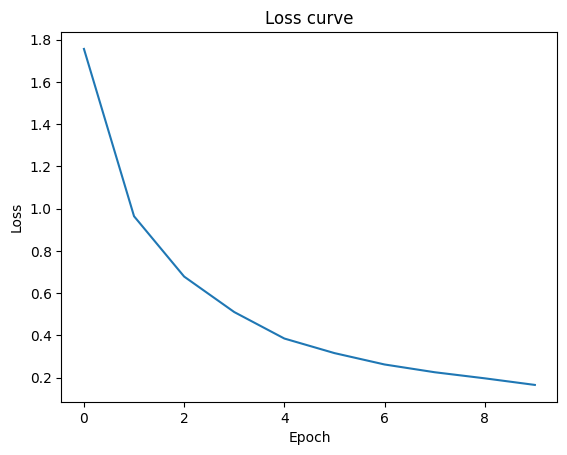

In [68]:
import matplotlib.pyplot as plt

num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    i = 0

    for inputs, targets in combined_data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        targets = torch.argmax(targets, dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        i += 1
        epoch_loss = running_loss / i
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

    epoch_loss = running_loss / i
    loss_history.append(epoch_loss)

print("Finished Training")

# Plot the loss curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.show()




In [69]:
test_dataset = CustomImageDataset(X_test.cpu().numpy(), y_test.cpu().numpy())
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(targets, dim=1)
        
        total += targets.size(0)
        correct += (predicted == true_labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")

Accuracy on test set: 66.625%


## Siamese nn

### Pair images dataset

In [ ]:
class ImagePairsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img1 = self.images[idx]
        label1 = self.labels[idx]

        idx2 = np.random.choice(len(self.images))
        img2 = self.images[idx2]
        label2 = self.labels[idx2]

        return (img1, img2), (label1, label2)

### Sift and lbp

In [ ]:
def extract_sift_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_image, None)
    return des

def extract_lbp_features(image, num_points, radius, method="uniform"):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = feature.local_binary_pattern(gray_image, num_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

### Pair features datasets

In [ ]:
class ImagePairsFeatureDataset(Dataset):
    def __init__(self, images, targets, num_lbp_points, lbp_radius):
        self.images = images
        self.targets = targets
        self.num_lbp_points = num_lbp_points
        self.lbp_radius = lbp_radius

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img1 = self.images[idx].astype('uint8')
        img2 = self.images[(idx + 1) % len(self.images)].astype('uint8')

        # Ensure that the images have 3 channels
        if img1.shape[2] != 3:
            img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
        if img2.shape[2] != 3:
            img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

        img1_sift = extract_sift_features(img1)
        img2_sift = extract_sift_features(img2)
        img1_lbp = extract_lbp_features(img1, self.num_lbp_points, self.lbp_radius)
        img2_lbp = extract_lbp_features(img2, self.num_lbp_points, self.lbp_radius)

        img1_features = np.concatenate((img1_sift, img1_lbp))
        img2_features = np.concatenate((img2_sift, img2_lbp))

        label1 = self.targets[idx]
        label2 = self.targets[(idx + 1) % len(self.targets)]

        return (torch.tensor(img1_features).float(), torch.tensor(img2_features).float()), (label1, label2)

### Siamese nn architecture

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        output1 = self.fc(x1)
        output2 = self.fc(x2)
        return output1, output2

### Training and evaluation

In [ ]:
def train_siamese_network(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        i = 0
        for (inputs1, inputs2), targets in dataloader:
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs1, outputs2 = model(inputs1, inputs2)
            loss = criterion(outputs1, targets) + criterion(outputs2, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            i += 1
            print(f"Epoch {epoch + 1}, Loss: {running_loss / i}")

    print("Finished Training")

In [ ]:
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for (inputs1, inputs2), targets in dataloader:
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            outputs1, outputs2 = model(inputs1, inputs2)
            predicted1 = torch.argmax(outputs1, dim=1)
            predicted2 = torch.argmax(outputs2, dim=1)

            correct += (predicted1 == targets).sum().item() + (predicted2 == targets).sum().item()
            total += 2 * targets.size(0)

    print(f"Accuracy: {100 * correct / total}%")

In [ ]:
num_lbp_points = 24
lbp_radius = 3

train_pairs_dataset = ImagePairsFeatureDataset(X_train.cpu().numpy(), y_train.cpu().numpy(), num_lbp_points, lbp_radius)
test_pairs_dataset = ImagePairsFeatureDataset(X_test.cpu().numpy(), y_test.cpu().numpy(), num_lbp_points, lbp_radius)

batch_size = 32
train_pairs_loader = DataLoader(train_pairs_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_pairs_loader = DataLoader(test_pairs_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

feature_dim = 128 + num_lbp_points * 2  # 128 for SIFT, num_lbp_points * 2 for LBP

siamese_net = SiameseNetwork(feature_dim, num_classes = 120).to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork(feature_dim, num_classes = 120).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
num_epochs = 10
running_loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, ((img1_features, img2_features), (label1, label2)) in enumerate(train_pairs_loader):
        img1_features = img1_features.to(device)
        img2_features = img2_features.to(device)
        label1 = label1.to(device)
        label2 = label2.to(device)

        optimizer.zero_grad()

        output1, output2 = siamese_net(img1_features, img2_features)
        loss = criterion(output1, output2, label1, label2)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / (i + 1)
    running_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

print("Finished Training")